In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
import random
from tqdm import tqdm
from scipy.interpolate import interp1d,interp2d
from scipy import stats
from scipy import integrate
from bayes_opt import BayesianOptimization
import json
# import seaborn as sns
from scipy import special
from scipy import integrate
from pymongo import MongoClient
import pymongo

In [2]:
#Define the constants
main_detune = 17
sideband_detune = 120
white_detune = 10
laser_on = 200000
laser_off = 400015
MOT_power = 50
v0_start=1
v0_step=1
v0_end=25
t0_start=0
t0_step=1
t0_end=3500000

Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
mag_field_grad = 1252.8168984164048*x0
waist = 0.012/x0
v_max = 8.
z_max = 0.012/x0
z_start = 0.012/x0
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
t_eval = np.arange(t0_start,t0_end,t0_step)

# The detunings used in the PRAs:
intensities = 2.*MOT_power*1e-3/(np.pi*0.012**2)/Isat

# Finding current

In [3]:
def Coil_field(I,R:np.array):
    n = 100
    s = 0.14 # in meter
    rad = 0.14 # in meter
    def dBx(theta,L):
        dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
        rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
        dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
        # print(dl,rprime,dB)
        return dB[0]
    def dBy(theta,L):
        dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
        rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
        dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
        return dB[1]
    
    def dBz(theta,L):
        dl = np.array([-rad*np.sin(theta),rad*np.cos(theta),0])
        rprime = R*x0 - np.array([0,0,L])+np.array([rad*np.cos(theta),rad*np.sin(theta),0])
        dB = cts.mu_0/(4*np.pi)*np.cross(dl,rprime)/((np.sum(rprime**2))**(3/2))*I
        return dB[2]
    
    
    Bx = integrate.quad(dBx,0,2*np.pi,args=(-s))[0]-integrate.quad(dBx,0,2*np.pi,args=(s))[0]
    By = integrate.quad(dBy,0,2*np.pi,args=(-s))[0]-integrate.quad(dBy,0,2*np.pi,args=(s))[0]
    Bz = integrate.quad(dBz,0,2*np.pi,args=(-s))[0]-integrate.quad(dBz,0,2*np.pi,args=(s))[0]
    
    return np.array([Bx,By,Bz])*n*10000 # Return in Gauss

In [14]:
def Error_function(I):
    connection = MongoClient("mongodb://localhost:27017")
    vc = connection.db.New_vc
    max_parameters = vc.find(projection={"_id" : 0}).sort("target",pymongo.DESCENDING).limit(1)

    B_grad_max = max_parameters[0]["params"]["Bgrad"]
    error = 0
    zz = np.linspace(-0.12,0.12,201)/x0
    for z in zz:
        B_true = B_grad_max*1000*z*x0
        B_coil = Coil_field(I,np.array([0,0,z]))[2]
        
        error += (B_true - B_coil)**2
    return np.sqrt(error)*-1

In [15]:
pbounds ={'I' : (0.5,100)}

In [16]:
optimizer = BayesianOptimization(f=Error_function,pbounds=pbounds,verbose=13,random_state=1)

In [17]:
optimizer.maximize(n_iter=1,init_points=1)

|   iter    |  target   |     I     |
-------------------------------------
|  1        | -42.63    |  41.99    |
|  2        | -1.142e+0 |  75.15    |


In [18]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path='./current.json')
optimizer.subscribe(Events.OPTIMIZATION_STEP,logger)

In [19]:
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   |     I     |
-------------------------------------
|  3        | -1.042e+0 |  72.17    |
|  4        | -1.369e+0 |  0.5114   |
|  5        | -358.8    |  30.58    |
|  6        | -878.5    |  15.1     |
|  7        | -1.06e+03 |  9.688    |
|  8        | -746.4    |  19.03    |
|  9        | -215.2    |  34.88    |
|  10       | -53.05    |  39.98    |
|  11       | -435.4    |  54.11    |
|  12       | -47.5     |  42.21    |
|  13       | -1.978e+0 |  100.0    |
|  14       | -33.37    |  41.21    |
|  15       | -33.4     |  41.16    |
|  16       | -33.38    |  41.17    |
|  17       | -33.38    |  41.18    |
|  18       | -33.37    |  41.18    |
|  19       | -33.37    |  41.19    |
|  20       | -33.37    |  41.19    |
|  21       | -33.37    |  41.19    |
|  22       | -33.37    |  41.19    |
|  23       | -33.37    |  41.19    |
|  24       | -33.41    |  41.15    |
|  25       | -33.38    |  41.24    |
|  26       | -33.46    |  41.13    |
|  27       

In [20]:
optimizer.max

{'target': -33.36694202497196, 'params': {'I': 41.20989450646772}}

In [21]:
optimizer.maximize()

|   iter    |  target   |     I     |
-------------------------------------
|  113      | -924.6    |  68.68    |
|  114      | -685.6    |  20.84    |
|  115      | -1.57e+03 |  87.87    |
|  116      | -1.278e+0 |  3.225    |
|  117      | -875.3    |  67.21    |
|  118      | -33.39    |  41.17    |
|  119      | -33.39    |  41.17    |
|  120      | -33.39    |  41.17    |
|  121      | -33.37    |  41.23    |
|  122      | -33.37    |  41.22    |
|  123      | -33.39    |  41.17    |
|  124      | -33.39    |  41.17    |
|  125      | -33.37    |  41.22    |
|  126      | -33.37    |  41.23    |
|  127      | -33.39    |  41.17    |
|  128      | -33.37    |  41.22    |
|  129      | -33.37    |  41.22    |
|  130      | -33.39    |  41.17    |
|  131      | -33.37    |  41.22    |
|  132      | -33.39    |  41.17    |
|  133      | -33.37    |  41.22    |
|  134      | -33.37    |  41.22    |
|  135      | -33.39    |  41.17    |
|  136      | -33.37    |  41.22    |
|  137      

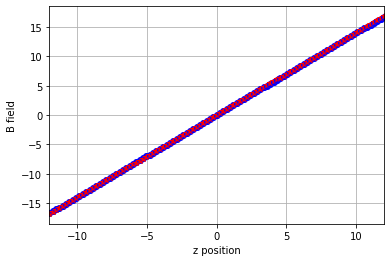

In [22]:
connection = MongoClient("mongodb://localhost:27017")
vc = connection.db.New_vc
max_parameters = vc.find(projection={'_id' : False, 'params' : 1}).sort("target",pymongo.DESCENDING).limit(1)
B_grad_max = max_parameters[0]["params"]['Bgrad']


Current = connection.db.Current
max_I = Current.find(limit=1,projection={'_id' : False, 'params' : 1}).sort("target",pymongo.DESCENDING)
I_opt = max_I[0]['params']['I']


fig,ax = plt.subplots(1,1)
zz = np.linspace(-0.012,0.012,101)/x0
# for xx in xs:
#     ax.plot(xx*x0*1000,B_func(np.array([xx,0,0]))[0],'bo')
#     ax.plot(xx*x0*1000,-1/2*1.2528*xx*x0*1000,'r*')

for zs in zz:
    ax.plot(zs*x0*1000,Coil_field(I_opt,zs)[2],'bo')
    ax.plot(zs*x0*1000,B_grad_max*1000*x0*zs,'r*')
    
ax.set_xlim(-12,12)
ax.set_xlabel("z position")
ax.set_ylabel("B field")
ax.grid()

# Confirm the coil`s 3D regular interpolator

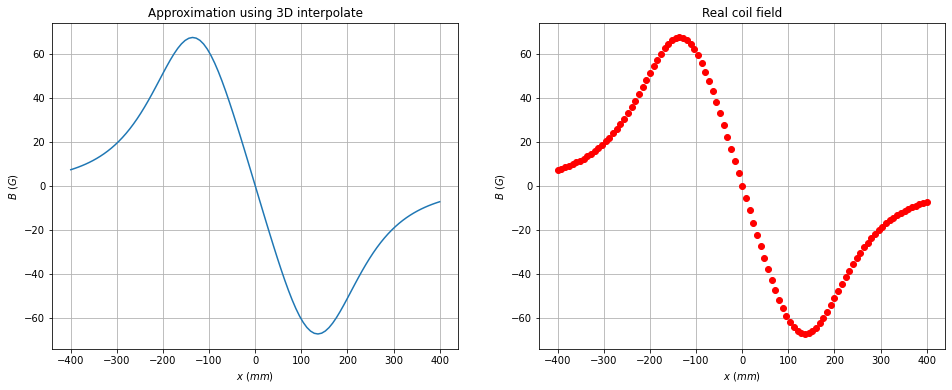

In [23]:
from scipy.interpolate import RegularGridInterpolator

xs = np.linspace(-0.4,0.4,101)/x0
ys = np.linspace(-0.4,0.4,101)/x0
zs = np.linspace(-0.14,0.14,101)/x0

X,Y,Z = np.meshgrid(xs,ys,zs,sparse=1,indexing="ij")
B = np.load("D:/migration/B_3D_interp_41.21.npy")


Bx = RegularGridInterpolator((xs,ys,zs),B[0])
By = RegularGridInterpolator((xs,ys,zs),B[1])
Bz = RegularGridInterpolator((xs,ys,zs),B[2])

def B_func(R:np.array):
    if abs(R[2])>0.2/x0 or abs(R[1])>0.4/x0 or abs(R[0])>0.4/x0:
        return np.zeros(3,)
    return np.array([Bx(R),By(R),Bz(R)]).reshape(-1)
def Bx_approx(x):
    return B_func(np.array([x,0.,0.]))[0]

Bx_approx_v = np.vectorize(Bx_approx)

fig, ax = plt.subplots(1,2,figsize=(16,6))

ax[0].plot(xs*x0*1000,Bx_approx_v(xs))
for xx in xs:
    ax[1].plot(xx*x0*1000,Coil_field(I_opt,np.array([xx,0,0]))[0],"ro")

ax[0].set_xlabel("$x\ ({mm}$)")
ax[0].set_ylabel("$B\ ({G}$)")
ax[0].set_title("Approximation using 3D interpolate")
ax[0].grid()
ax[1].set_xlabel("$x\ ({mm}$)")
ax[1].set_ylabel("$B\ ({G}$)")
ax[1].set_title("Real coil field")
ax[1].grid()

fig.savefig("D:/pr/Bfield.png")
